# Transforms Group

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#Export

#Internal dependencies
from exp.nb_AudioCommon import * 
from exp.nb_DataAugmentation import * 

## Common Functions 

In [ ]:
#Export
import ipywidgets as widgets

TfmsGroups = [TfmList]

In [ ]:
#Export
def flatten(x, flattenStrings=False):
    '''Transforms [[x]] in [x]'''
    if not flattenStrings:
        if isinstance(x,str):
            return [x]
    if isinstance(x, collections.Iterable):
        return [a for i in x for a in flatten(i)]
    else:
        return [x]

In [ ]:
def test_flatten():
    A=[[1,2],[3,4,5]]
    assert [1,2,3,4,5] == flatten(A)
    
    B = [A]
    assert [1,2,3,4,5] == flatten(B)

    C = [[1,2],3,[4,5]]
    assert [1,2,3,4,5] == flatten(C)
    
    print('DONE')

test_flatten()

In [ ]:
def test_flatten_with_string():
    A='abcd'
    assert ['abcd'] == flatten(A)

    B=['ab','cd']
    assert ['ab','cd'] == flatten(B)

    C=[['hello'],' ',['world']]
    assert ['hello',' ','world'] == flatten(C)

    print('DONE')
    
test_flatten_with_string()

In [ ]:
#Export
def getTfmList(g:TfmsGroups, up_to_grpup=None)->TfmList:
    '''Returns transformations up to specified group included'''
    grps = g if up_to_grpup is None else [x for i,x in enumerate(g) if i<=up_to_grpup] 
    ret = flatten(grps)
    ret = [t for t in ret if []!=t] # filter none
    return ret

In [ ]:
def test_getTfmList():
    g = [[torchaudio.transforms.Scale, torchaudio.transforms.PadTrim],[torchaudio.transforms.MEL]]
    assert 3==len(getTfmList(g))
    assert 2==len(getTfmList(g,0))
    assert 3==len(getTfmList(g,1))
    print('DONE')
    
test_getTfmList()

In [ ]:
#Export
def applyTfms(tfms:TfmList, x):
    '''Apply a list of transformations'''
    ret = x
    for tfm in tfms:
        ret = tfm(ret)
    return ret

## Custom Widgets

In [ ]:
#Export
def titleBox(title:str, w=None, hasBorder=True):
    '''Returns a widget that "wraps" the widget <w> with a box'''
    props = dict(display='flex',
                flex_flow='column',
                align_items='stretch',
                width='100%')
    if hasBorder: 
        props['border']='solid'
    box_layout = widgets.Layout(**props)
    centered_text = widgets.Layout(color='red')
    lblw = widgets.Label(value=title, Layout=centered_text) # Should center align.. 
    if w: 
        return widgets.VBox(children=[lblw,w], layout=box_layout)
    else:
        return widgets.VBox(children=[lblw], layout=box_layout)        

In [ ]:
def test_titleBox():
    out = titleBox('hello',widgets.Label('world'))
    display(out)
    # No border
    display(titleBox('hello - no border',widgets.Label('world'), hasBorder=False))
    # No content
    display(titleBox('hello - no elements inside',None))
    
test_titleBox()

In [ ]:
#Export
def getImageWidget(img):
    out = widgets.Output()
    with out:
        display(Image(img))
    return out

In [ ]:
def test_getImageWidget():
    img = torch.zeros(1,100,200)
    out = getImageWidget(img)
    display(out)
    
test_getImageWidget()

In [ ]:
#Export 
def getTransformsWidget(tfms):
    items = []
    for i,t in enumerate(tfms):
        items.append(widgets.Label(f'{i}:\t' + str(t)))
    return widgets.VBox(children=items)

In [ ]:
def test_getTransformsWidget():
    tfms = ['abcd','cdef','zzz']
    display(getTransformsWidget(tfms))
    
test_getTransformsWidget()

## Transformations Manager

In all the situation where there are complex transformtations (ie: an augmented sound that becomes an image), TfmsManager can help you to **group transformations into meaningful groups that can be easily tested separately**.
Once you've completed the fine tuning step of each group of transformations, **get_tfms()** consolidate your work and generates the final transform list compatible with fast.ai.

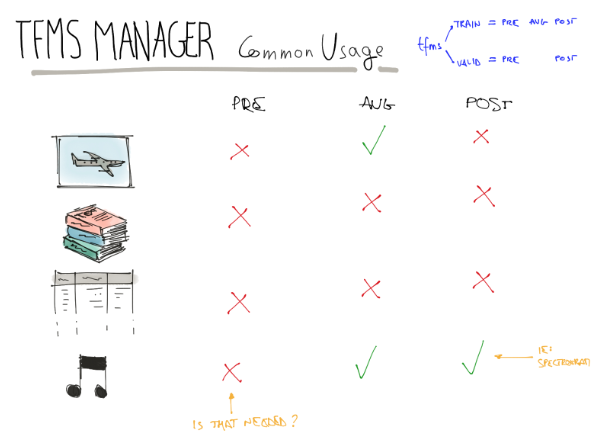

In [ ]:
#Export
class TfmsManager:
    def __init__(self, train_tfms_groups:TfmsGroups, valid_tfms_groups:TfmsGroups):
        self.train_tfmsg, self.valid_tfmsg = listify(train_tfms_groups), listify(valid_tfms_groups)
    
    def get_tfms(self)->[TfmList,TfmList]:
        return [self.get_train_tfms(up_to_grpup=None), self.get_valid_tfms(up_to_grpup=None)]

#Training set functions
    def get_train_tfms(self, up_to_grpup=None)->TfmList:
        return getTfmList(self.train_tfmsg,up_to_grpup)    
        
    def apply_train_tfms(self, x, up_to_grpup=None):
        return applyTfms(self.get_train_tfms(up_to_grpup),x)
    
#Validation set functions 
    def get_valid_tfms(self, up_to_grpup=None)->TfmList:
        return getTfmList(self.valid_tfmsg,up_to_grpup)

    def apply_valid_tfms(self, x, up_to_grpup=None):
        return applyTfms(self.get_train_tfms(up_to_grpup),x)

    @classmethod
    def create_from_main_groups(cls, pre:TfmList, aug:TfmList, size:TfmList, post:TfmList):
        '''Create TfmsManager from three main components:
        + pre: pre data augmentation transforms
        + aug: data augmentation transforms
        + post: post data augmentation transforms
        
        NB: train_tfms = [pre,aug,size,post]
            valid_tfms = [pe,size,post]
        '''
        return cls([pre,aug,size,post],[pre,size,post])

**IMPORTANT**: to use TfmsManager with fast.ai use:

```python
tm = TfmsManager.create_from_main_groups(...)

tfms = tm.get_tfms() # THIS ROW ADAPT THE TRANSFORMATIONS TO fast.ai

data = (ImageList.from_folder(path) #Where to find the data? -> in path and its subfolders
        .split_by_folder()              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .add_test_folder()              #Optionally add a test set (here default name is test)
        .transform(tfms, size=64)       #Data augmentation? -> use tfms with a size of 64
        .databunch())                   #Finally? -> use the defaults for conversion to ImageDataBunch
```

## Transformations Manager: customize for Audio

### Audio sample data

In [ ]:
# Download data in fast.ai format (thnx @Thom)
data_url = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
path = datapath4file('ST-AEDS-20180100_1-OS')
untar_data(data_url, dest = path)

In [ ]:
sampleFile = path.ls()[4]
sampleFile

In [ ]:
sampleSound = AudioData.load(sampleFile)
display(Audio(sampleSound.sig,rate=sampleSound.sr))

### Audio Widgets

In [ ]:
#Export
def getAudioWidget(ad:AudioData):
    out = widgets.Output()
    if ad:
        with out: 
            display(Audio(ad.sig,rate=ad.sr))
    # if None = ad => nothing to display
    return out

In [ ]:
def test_getAudioWidget():
    out = getAudioWidget(sampleSound)
    display(out)
    # Nothing to display
    display(getAudioWidget(None))

test_getAudioWidget()

### AudioTfmsManager

In [ ]:
t=widgets.Tab()
t.set_title

In [ ]:
#Export
class AudioTfmsManager(TfmsManager):
    
    def try_data_augmentation(self,ad:AudioData, lbl:str=None, showResults=True, **kwargs)->AudioData:
        '''Try to apply data augmentation only and show labels'''
        tfms = self.get_train_tfms(2)
        y=applyTfms(tfms,ad) # All tfms
        if showResults: 
            out=widgets.Output()
            with out:
                self.showAudio(y,lbl,ad,**kwargs)
            wTfms = getTransformsWidget(tfms)
            tabs = widgets.Tab(children=[out,wTfms])
            tabs.set_title(0,'RESULT')
            tabs.set_title(1,'TFMS')
            display(tabs)
        return y

    def try_spectrogram(self,ad:AudioData, lbl:str=None, showResults=True, **kwargs):
        '''Apply all other tfms after data augmentation'''
        tfms = getTfmList(self.train_tfmsg[2:])
        y=applyTfms(tfms,ad) # All valid tfms - no data augmentation
        if showResults: 
            out=widgets.Output()
            with out:
                self.showSpec(y,lbl,**kwargs)
            wTfms = getTransformsWidget(tfms)
            tabs = widgets.Tab(children=[out,wTfms])
            tabs.set_title(0,'RESULT')
            tabs.set_title(1,'TFMS')
            display(tabs)
        return y
    
    def try_train_tfms(self,ad:AudioData, lbl:str=None, showResults=True, **kwargs):
        '''Try to apply all train transforms to an audio signal'''
        y, yaug=None, None
        #Aug
        aug = widgets.Output()
        with aug:
            yaug=self.try_data_augmentation(ad,lbl=None,showResults=True,**kwargs)

        spec = widgets.Output()
        with spec:
            y = self.try_spectrogram(yaug, lbl=None, **kwargs)
        
        wAug = titleBox('DATA AUGMENTATION:', aug)
        wSpec = titleBox('SPECTROGRAM:', spec)

        #wFooter = titleBox(f'TIME: {}')
        
        out = display(titleBox(lbl,widgets.VBox(children=[wAug,wSpec])))
        display(out)
        return y        
    
    def showAudio(self, dst:AudioData, lbl, src:AudioData=None, showSound=True, showPlot=True, showSource=True, **kwargs):
        if showSound: 
            if(lbl): display(f'Label: {lbl}')
            wSrc = getAudioWidget(src) # empty widget if none...
            wDst = getAudioWidget(dst)
            wrow = widgets.HBox(children = [wSrc, wDst])
            display(wrow)
        if showPlot:
            if (src is not None) and showSource: plt.plot(src.sig, 'r')
            if dst is not None: plt.plot(dst.sig, 'b')
            plt.show() # Force chart to display

    def showSpec(self, spec:torch.Tensor, lbl:str=None, **kwargs):
        '''Shape Should be (n_channels,hh,ww)'''
        if lbl: display(f'Label: {lbl}')
        toShow = []
        for i in range(spec.shape[0]):
            img = spec[i,:,:].unsqueeze(0) # need to unsqueeze because Image whats 1xHxW
            toShow.append(titleBox(f'C:{i}', getImageWidget(img)))
        if toShow: display(widgets.HBox(children=toShow))
            
    @classmethod
    def get_audio_tfms_manager(cls,
                             spectro:bool=False,
                             white_noise:bool=True,
                             modulate_volume:bool=True,
                             random_cutout:bool=True,
                             pad_with_silence:bool=True,
                             pitch_warp:bool=True,
                             down_and_up:bool=True,
                             mx_to_pad:int=1000,
                             xtra_pre_tfms:TfmList=None,
                             xtra_aug_tfms:TfmList=None,
                             xtra_post_tfms:TfmList=None,
                             **kwargs)->TfmsManager:
        '''factory to create audio transforms manager.'''
        pre = [] + listify(xtra_pre_tfms)
        
        aug = []
        if white_noise: aug.append(partial(tfm_add_white_noise, **kwargs))
        if modulate_volume: aug.append(partial(tfm_modulate_volume, **kwargs))
        if random_cutout: aug.append(partial(tfm_random_cutout, **kwargs))
        if pad_with_silence: aug.append(partial(tfm_pad_with_silence, **kwargs))
        if pitch_warp: aug.append(partial(tfm_pitch_warp, **kwargs))
        if down_and_up: aug.append(partial(tfm_down_and_up, **kwargs))
        aug += listify(xtra_aug_tfms)

        size = []
        if mx_to_pad: size.append(partial(tfm_pad_to_max, mx=mx_to_pad))
        
        post = []
        post += [partial(tfm_spectro, **kwargs) if spectro else partial(tfm_extract_signal, **kwargs)]
        post += listify(xtra_post_tfms)
        
        return cls.create_from_main_groups(pre,aug,size,post)

In [ ]:
#Show all results
tm=AudioTfmsManager.get_audio_tfms_manager(
                         spectro=True, n_mels=256, ws=300, n_fft=3200, to_db_scale=True,
                         white_noise=True, noise_scl=.00052,
                         modulate_volume=False,
                         random_cutout=False,
                         pad_with_silence=False,
                         pitch_warp=False,
                         down_and_up=False,
                         mx_to_pad=32000)
tm.try_train_tfms(sampleSound,'Show all');

In [ ]:
def test_get_audio_tfms_manager():
    tm=AudioTfmsManager.get_audio_tfms_manager()

    # fast.ai integration
    tfms = tm.get_tfms()
    print('fast.ai tfms = ',tfms)
    assert 2==len(tfms), 'tfms tuple for fast.ai'
    assert 8==len(tfms[0]), 'train transformations'
    assert 2==len(tfms[1]), 'valid transformations'
    
    assert 8==len(tm.get_train_tfms())
    assert 2==len(tm.get_valid_tfms())
    assert 7==len(tm.get_train_tfms(2)) # data augmentation -> pre+aug
    
    tm=AudioTfmsManager.get_audio_tfms_manager(
                         spectro=True,
                         white_noise=False,
                         modulate_volume=False,
                         random_cutout=False,
                         pad_with_silence=False,
                         pitch_warp=False,
                         down_and_up=False,
                         mx_to_pad=1000)
    assert 2==len(tm.get_train_tfms())
    assert 2==len(tm.get_valid_tfms())

    print('DONE')
    
test_get_audio_tfms_manager()

### SAMPLE USAGE FOR AUDIO
Pretend that you want identify who is talking in a registratio. This is a tipical classificaiton problem. A way to address this problem is taking the first 2 seconds of the original sound, converting it into a MEL spectrogram and feed a CNN to classify it as it was an image.

If you want to improve the performance and the generalization of your model, one simple way is to use data augmentation, like on images.
The problem with sound is that you need to make the data augmentation (**AUG**) on the original sound, and to understand if you're doing this correctly you need to "HEAR" (listen) and "VIEW" (plot soundwave) your augmented sound.
Moreover, once you're sure about your data augmentation, you need to tune your spectrogram (**POST**) in such way that you're preserve as much information as possible for the next steps.

TfmsManager can help you in all this steps, so you can create and test independently all the transformation groups that you need. 

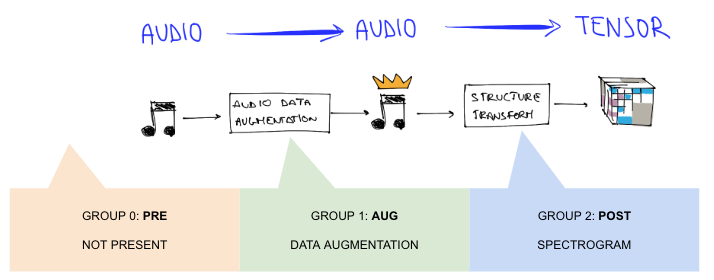

Download some test data...

### TfmsManager sample usage:
With AudioTfmsManager you can easily test separately all your transformation groups:
* DATA AUGMENTATION (AUG)
* SPECTROGRAM (POST)
<br>
<br>
Having a quick audio/visual feedback on them.

In [ ]:
#Show all results
tm=AudioTfmsManager.get_audio_tfms_manager(
                         spectro=True, n_mels=256, ws=300, n_fft=3200, to_db_scale=True,
                         white_noise=True, noise_scl=.00052,
                         modulate_volume=False,
                         random_cutout=False,
                         pad_with_silence=False,
                         pitch_warp=False,
                         down_and_up=False,
                         mx_to_pad=32000)
tm.try_train_tfms(sampleSound,'Show all');

In [ ]:
#Show efect of data augmentation only
tm.try_data_augmentation(sampleSound,'Show data augmentatio on signal only');

In [ ]:
#Show effects of spectrogram only
tm.try_spectrogram(sampleSound,'Spectrogram without data augmentation');

### Use case: find correct parameters for data augmentation  

In [ ]:
tm=AudioTfmsManager.get_audio_tfms_manager(spectro=True)
tm.try_data_augmentation(sampleSound,'test')

**WARNING**: these transformations completely destroy the original information...

In [ ]:
tm=AudioTfmsManager.get_audio_tfms_manager(
                         spectro=True,
                         white_noise=True, noise_scl=.00052,
                         modulate_volume=False,
                         random_cutout=False,
                         pad_with_silence=False,
                         pitch_warp=False,
                         down_and_up=False,
                         mx_to_pad=32000)    
tm.try_data_augmentation(sampleSound,'test')

### Use case: find correct parameters for spectrogram generation and multi spectrogram

In [ ]:
def tfm_cropSpec(spec:torch.Tensor, yStart, yEnd)->torch.Tensor:
    #yStart = int(math.floor(yStart))
    #yEnd = int(math.floor(yEnd))
    #print(spec.shape, yStart, yEnd, yEnd-yStart)
    ret = spec[:,:,yStart:yEnd]
    #print(ret.shape)
    return ret

def tfm_multiSpectrumSlide(ad:AudioData, max_duration=1600)->torch.Tensor:
    '''This transformation is going to produce a 3-channels spectrum image from sliding windows'''
    minLenForSpec = 6401
    maxWW = max(minLenForSpec,max_duration) # max width
    
    padded = tfm_pad_to_max(ad, maxWW) # Ensure constant lenght
    spec = tfm_spectro(padded, n_mels=224, ws=50, n_fft=3200*2, to_db_scale=True) # Spectrogram of all

    wndWidth = 140 # in spec cols
    maxSpecCols = spec.shape[2]
    n_windows = 3
    wndStep = (maxSpecCols - wndWidth)/(n_windows-1)
    wndStep = int(math.floor(wndStep)) # make it integer
    
    #print(wndWidth, wndStep)
    
    n=0
    ret = None
    ret = tfm_cropSpec(spec,(n*wndStep),((n)*wndStep)+wndWidth) # Sliding window
    wMax = ret.shape[2]
    
    n=1
    img = tfm_cropSpec(spec,(n*wndStep),((n)*wndStep)+wndWidth)
    ret = torch.cat([ret,img],dim=0) # Stack...

    n=2
    img = tfm_cropSpec(spec,(n*wndStep),((n)*wndStep)+wndWidth)
    ret = torch.cat([ret,img],dim=0) # Stack...

    return ret

In [ ]:
tm=AudioTfmsManager.get_audio_tfms_manager(
                         spectro=True, n_mels=256, ws=300, n_fft=3200, to_db_scale=True,
                         white_noise=True, noise_scl=.00052,
                         modulate_volume=False,
                         random_cutout=False,
                         pad_with_silence=False,
                         pitch_warp=False,
                         down_and_up=False,
                         mx_to_pad=32000)    

#Replace the spectrogram transform with tfm_spectro_stft
filan_spec_tfm = partial(tfm_multiSpectrumSlide, max_duration=1000)
tm.train_tfmsg[-1]=[filan_spec_tfm]
tm.valid_tfmsg[-1]=[filan_spec_tfm]

#Try!
tm.try_train_tfms(sampleSound,'test')

# Export

In [ ]:
!python notebook2script.py TransformsManager.ipynb